In [5]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# Corrected import for Keras Tuner
from kerastuner import HyperModel, RandomSearch

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

# Define the hypermodel class
class ConvolutionalHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        
    def build(self, hp):
        model = models.Sequential()
        model.add(layers.Conv2D(
            filters=hp.Choice('filters_0', [32, 64, 128, 256]),
            kernel_size=(3, 3),
            activation='relu',
            input_shape=self.input_shape))
        model.add(layers.MaxPooling2D((2, 2)))
        
        for i in range(1, hp.Int('num_layers', 2, 9)):
            model.add(layers.Conv2D(
                filters=hp.Choice(f'filters_{i}', [32, 64, 128, 256]),
                kernel_size=(3, 3),
                activation='relu'))
            model.add(layers.MaxPooling2D((2, 2)))
        
        model.add(layers.Flatten())
        model.add(layers.Dense(units=256, activation='relu'))
        model.add(layers.Dropout(0.1))
        layers.Dense(32, activation='relu'),
        model.add(layers.Dense(self.num_classes, activation='softmax'))
        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

# Adjusted for RGB images
input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

hypermodel = ConvolutionalHyperModel(input_shape, num_classes)

# Define directory paths
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')
test_dir = os.path.join(dataset_folder, 'test')

# Load in images with color_mode='rgb'
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',  # Load images in RGB
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',  # Load images in RGB
    class_mode='categorical')

# Initialize the Random Search
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='cnn_tuning'
)

# Execute the search
tuner.search(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# After tuning, retrieve the best model and print its summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 10 Complete [00h 00m 00s]

Best val_accuracy So Far: 0.59375
Total elapsed time: 00h 20m 21s
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 510, 510, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2  (None, 255, 255, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 253, 253, 64)      36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 126, 126, 64)      0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 1016064)           0         
                       

Found 186 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Epoch 1/10
5/5 [==============================] - 10s 2s/step - loss: 20900.8945 - accuracy: 0.3117 - val_loss: 2275.5981 - val_accuracy: 0.3125
Epoch 2/10
5/5 [==============================] - 10s 2s/step - loss: 764.9963 - accuracy: 0.3636 - val_loss: 4.1569 - val_accuracy: 0.6875
Epoch 3/10
5/5 [==============================] - 10s 2s/step - loss: 17.8917 - accuracy: 0.5875 - val_loss: 12.6771 - val_accuracy: 0.2188
Epoch 4/10
5/5 [==============================] - 9s 2s/step - loss: 7.0541 - accuracy: 0.6818 - val_loss: 21.1516 - val_accuracy: 0.1562
Epoch 5/10
5/5 [==============================] - 10s 2s/step - loss: 4.2412 - accuracy: 0.7063 - val_loss: 2.4476 - val_accuracy: 0.4062
Epoch 6/10
5/5 [==============================] - 9s 2s/step - loss: 1.1458 - accuracy: 0.9026 - val_loss: 1.8735 - val_accuracy: 0.6250
Epoch 7/10
5/5 [==============================] - 10s 2s/step - loss: 1.6121 - ac

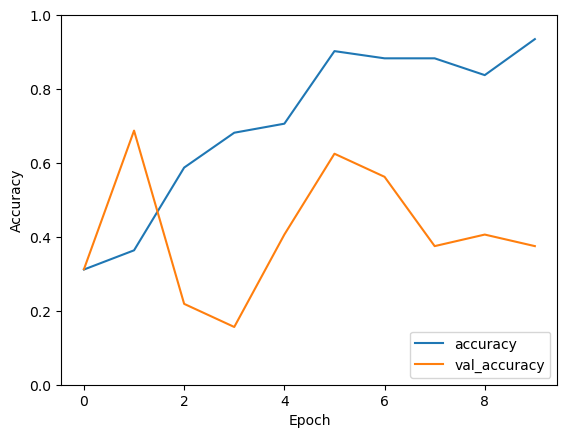

In [13]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

# Define paths
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

# Define the best model architecture
def build_best_model(input_shape, num_classes):
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.1),
        layers.Dense(num_classes, activation='softmax')
    ])
    
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

# Build the best model based on the architecture found
best_model = build_best_model(input_shape, num_classes)

# Define directory paths for the split dataset
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')
test_dir = os.path.join(dataset_folder, 'test')

# ImageDataGenerator instances for training and validation
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',
    class_mode='categorical')

# Train the model
history = best_model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# Optionally, plot the training history for accuracy and loss
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

plt.show()

# After training, you can evaluate the model on your test dataset, if needed


In [19]:
import os
import shutil
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
# Updated import for Keras Tuner
from keras_tuner import HyperModel, RandomSearch

# Assuming dataset_folder is defined and points to your dataset directory
dataset_folder = 'C:\\Users\\Alexandra\\Documents\\SPRING_2024\\BMEN_689\\Project_2\\Jupyter_Notebook\\512x512_Phage_EMs\\'

# Function to split dataset into train/validation/test
def split_dataset(data_folder, train_size=0.6, val_size=0.2, test_size=0.2):
    for class_folder in os.listdir(data_folder):
        class_path = os.path.join(data_folder, class_folder)
        if os.path.isdir(class_path):
            files = os.listdir(class_path)
            train_files, test_files = train_test_split(files, test_size=val_size+test_size, random_state=42)
            val_files, test_files = train_test_split(test_files, test_size=test_size/(val_size+test_size), random_state=42)

            train_folder = os.path.join(data_folder, 'train', class_folder)
            val_folder = os.path.join(data_folder, 'validation', class_folder)
            test_folder = os.path.join(data_folder, 'test', class_folder)
            for folder in [train_folder, val_folder, test_folder]:
                if not os.path.exists(folder):
                    os.makedirs(folder)

            for file in train_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(train_folder, file))
            for file in val_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(val_folder, file))
            for file in test_files:
                shutil.copy(os.path.join(class_path, file), os.path.join(test_folder, file))

# Call the function to split the dataset
split_dataset(dataset_folder)

class ConvolutionalHyperModel(HyperModel):
    def __init__(self, input_shape, num_classes):
        self.input_shape = input_shape
        self.num_classes = num_classes
        
    def build(self, hp):
        model = models.Sequential()
        model.add(layers.Conv2D(
            filters=hp.Choice('filters_0', [32, 64, 128, 256]),
            kernel_size=(3, 3),
            activation='relu',
            input_shape=self.input_shape))
        model.add(layers.MaxPooling2D((2, 2)))
        
        # Convolutional layers
        for i in range(1, hp.Int('num_conv_layers', 2, 5)):
            model.add(layers.Conv2D(
                filters=hp.Choice(f'filters_{i}', [32, 64, 128, 256]),
                kernel_size=(3, 3),
                activation='relu'))
            model.add(layers.MaxPooling2D((2, 2)))
        
        model.add(layers.Flatten())
        
        # Correctly configuring Dense layers based on hyperparameters
        for i in range(hp.Int('num_dense_layers', 1, 3)):
            model.add(layers.Dense(
                units=hp.Choice(f'units_dense_{i}', [32, 64, 128, 256]),
                activation='relu'))
            # Ensuring dropout layers are correctly added based on hyperparameters
            if hp.Boolean(f'dropout_{i}'):
                model.add(layers.Dropout(hp.Float(f'dropout_rate_{i}', min_value=0.1, max_value=0.5, step=0.1)))
        
        model.add(layers.Dense(self.num_classes, activation='softmax'))
        
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        return model

input_shape = (512, 512, 3)  # Use 3 channels for RGB images
num_classes = 3

hypermodel = ConvolutionalHyperModel(input_shape, num_classes)

# Define directory paths
train_dir = os.path.join(dataset_folder, 'train')
validation_dir = os.path.join(dataset_folder, 'validation')
test_dir = os.path.join(dataset_folder, 'test')

# Load in images with color_mode='rgb'
train_datagen = ImageDataGenerator()
validation_datagen = ImageDataGenerator()

batch_size = 32
target_size = (512, 512)

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',  # Load images in RGB
    class_mode='categorical')

validation_generator = validation_datagen.flow_from_directory(
    validation_dir,
    target_size=target_size,
    batch_size=batch_size,
    color_mode='rgb',  # Load images in RGB
    class_mode='categorical')

# Initialize the Random Search tuner
tuner = RandomSearch(
    hypermodel,
    objective='val_accuracy',
    max_trials=10,
    executions_per_trial=1,
    directory='hyperparam_tuning',
    project_name='cnn_tuning'
)

# Execute the search
tuner.search(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=10
)

# After tuning, retrieve the best model and print its summary
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Found 186 images belonging to 3 classes.
Found 63 images belonging to 3 classes.
Reloading Tuner from hyperparam_tuning\cnn_tuning\tuner0.json


ValueError: Received incompatible tensor with shape (256,) when attempting to restore variable with shape (32,) and name dense/bias:0.